In [ ]:
!pip install datasets==3.6.0 -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 12.8 MB/s eta 0:00:00


In [ ]:
import pandas as pd
from datasets import load_dataset_builder, Split
from torch.utils.data import DataLoader
from torch.utils.data.sampler import BatchSampler, RandomSampler, SequentialSampler
import torchaudio
import os
from transformers import Wav2Vec2Processor, Wav2Vec2ForCTC
import torch
import soundfile as sf
import numpy as np
from datasets import Audio

In [ ]:
!pip install jiwer -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 50.5 MB/s eta 0:00:00


In [ ]:
!pip install -U openai-whisper -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 803.2/803.2 kB 15.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
import whisper
import jiwer

In [ ]:
# Explicit builder
builder = load_dataset_builder(
    "tobiolatunji/afrispeech-200",
    name="pidgin"
)

# Run dataset script
builder.download_and_prepare()

# Create dataset
pidgin_speech = builder.as_dataset()

train_ds = pidgin_speech[Split.TRAIN]
dev_ds   = pidgin_speech[Split.VALIDATION]
test_ds  = pidgin_speech[Split.TEST]

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

afrispeech-200.py: 0.00B [00:00, ?B/s]

accent_stats.py: 0.00B [00:00, ?B/s]

The repository for tobiolatunji/afrispeech-200 contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/tobiolatunji/afrispeech-200.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


audio/pidgin/train/train_pidgin_0.tar.gz:   0%|          | 0.00/440M [00:00<?, ?B/s]

audio/pidgin/dev/dev_pidgin_0.tar.gz:   0%|          | 0.00/18.7M [00:00<?, ?B/s]

audio/pidgin/test/test_pidgin_0.tar.gz:   0%|          | 0.00/33.9M [00:00<?, ?B/s]

transcripts/pidgin/train.csv:   0%|          | 0.00/156k [00:00<?, ?B/s]

transcripts/pidgin/dev.csv:   0%|          | 0.00/7.85k [00:00<?, ?B/s]

transcripts/pidgin/test.csv:   0%|          | 0.00/15.1k [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]


Reading metadata...: 439it [00:00, 55817.25it/s]


Generating validation split: 0 examples [00:00, ? examples/s]


Reading metadata...: 26it [00:00, 31354.77it/s]


Generating test split: 0 examples [00:00, ? examples/s]


Reading metadata...: 45it [00:00, 55924.05it/s]


In [ ]:
train_ds[0]

{'speaker_id': 'eea10859e46f925f9e040f8981febbd6',
 'path': '/root/.cache/huggingface/datasets/downloads/extracted/7c4636c463951f874ad3b2384b6abbd777c26353ccfd6f8b313c0fde5e132ef6/6d3d593b-05e6-4692-bc34-1b19f38a42da/f58c5f8b3aab06d7adcc9ac723155ef0.wav',
 'audio_id': '6d3d593b-05e6-4692-bc34-1b19f38a42da/f58c5f8b3aab06d7adcc9ac723155ef0',
 'audio': {'path': '/root/.cache/huggingface/datasets/downloads/extracted/7c4636c463951f874ad3b2384b6abbd777c26353ccfd6f8b313c0fde5e132ef6/6d3d593b-05e6-4692-bc34-1b19f38a42da/f58c5f8b3aab06d7adcc9ac723155ef0.wav',
  'array': array([-0.00012207,  0.00045776,  0.00137329, ...,  0.00183105,
          0.00244141,  0.00311279]),
  'sampling_rate': 44100},
 'transcript': 'Pt had been given ambient at 1am for complaints of being unable to sleep.',
 'age_group': '19-25',
 'gender': 'Male',
 'accent': 'pidgin',
 'domain': 'clinical',
 'country': 'NG',
 'duration': 8.8289794921875}

In [ ]:
def normalize_audio(in_path, out_path):
    waveform, sr = torchaudio.load(in_path)
    waveform = torchaudio.functional.resample(waveform, sr, 16000)
    waveform = waveform.mean(dim=0, keepdim=True)  # mono
    torchaudio.save(out_path, waveform, 16000)

In [ ]:
import re

def normalize_text(text):
    text = text.lower()
    text = re.sub(r"[^\w\s]", " ", text)   # remove punctuation
    text = re.sub(r"\s+", " ", text)       # collapse multiple spaces
    return text.strip()
def normalize_transcript(example):
    example["transcript"] = normalize_text(example["transcript"])
    return example

test_ds = test_ds.map(normalize_transcript)

Map:   0%|          | 0/45 [00:00<?, ? examples/s]

In [ ]:
train_df = train_ds.to_pandas()
dev_df   = dev_ds.to_pandas()
test_df  = test_ds.to_pandas()

In [ ]:
train_df = train_df.drop(columns=["audio"])
dev_df = dev_df.drop(columns=["audio"])
test_df = test_df.drop(columns=["audio"])

In [ ]:
test_df.head()

,speaker_id,path,audio_id,transcript,age_group,gender,accent,domain,country,duration
0,07314a953e477ce489382c19e7603432,/root/.cache/huggingface/datasets/downloads/ex...,d4336ca9-6f12-4115-9a5f-e5906b05e05e/e018849df...,she was selected best young player awards in 2...,,Female,pidgin,general,NG,6.475986
1,e490782917bf84d6f23b9a020b623c3b,/root/.cache/huggingface/datasets/downloads/ex...,65950c41-64a1-475e-8d2d-91bec589077d/c734a807b...,managementi n primary hyperparathyroidism surg...,19-25,Male,pidgin,clinical,NG,7.102993
2,e490782917bf84d6f23b9a020b623c3b,/root/.cache/huggingface/datasets/downloads/ex...,91d01ed8-fd52-4eea-981a-e7befa87c1b0/0378fedc7...,minor anaphylactic reactions such as urticaria...,19-25,Male,pidgin,clinical,NG,9.523991
3,e490782917bf84d6f23b9a020b623c3b,/root/.cache/huggingface/datasets/downloads/ex...,b84a8392-cffd-45e7-95f2-ce91b0baf80d/d4616923d...,type ii saccular diverticulum of an extrahepat...,19-25,Male,pidgin,clinical,NG,6.661995
4,e490782917bf84d6f23b9a020b623c3b,/root/.cache/huggingface/datasets/downloads/ex...,9512e22e-52bd-4abe-80db-9dbea078362d/f708520ee...,the nature of a chronic ulcer white or red les...,19-25,Male,pidgin,clinical,NG,8.570998


# Whisper Model Baseline

In [ ]:
whisperModel = whisper.load_model("small")

def transcribe_audio(audio_path):
  result = whisperModel.transcribe(audio_path, language = "en")
  return result["text"]

100%|███████████████████████████████████████| 461M/461M [00:06<00:00, 73.9MiB/s]


In [ ]:
from datasets import Audio

test_ds_audio = test_ds.cast_column("audio", Audio(sampling_rate=16000))

In [ ]:
def transcribe_example(example):
    audio_array = example["audio"]["array"].astype(np.float32)
    result = whisperModel.transcribe(audio_array, fp16=False, language = "en")
    example["whisper_pred"] = result["text"]
    return example

In [ ]:
test_ds_audio = test_ds_audio.map(transcribe_example)

Parameter 'function'=<function transcribe_example at 0x7922da6f6520> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


Map:   0%|          | 0/45 [00:00<?, ? examples/s]

In [ ]:
test_df["whisper_pred"] = test_ds_audio["whisper_pred"]

In [ ]:
test_df.head()

,speaker_id,path,audio_id,transcript,age_group,gender,accent,domain,country,duration,whisper_pred
0,07314a953e477ce489382c19e7603432,/root/.cache/huggingface/datasets/downloads/ex...,d4336ca9-6f12-4115-9a5f-e5906b05e05e/e018849df...,she was selected best young player awards in 2...,,Female,pidgin,general,NG,6.475986,She was selected Best Young Player Award in 2...
1,e490782917bf84d6f23b9a020b623c3b,/root/.cache/huggingface/datasets/downloads/ex...,65950c41-64a1-475e-8d2d-91bec589077d/c734a807b...,managementi n primary hyperparathyroidism surg...,19-25,Male,pidgin,clinical,NG,7.102993,"Management and primary hyperparaderoism, so t..."
2,e490782917bf84d6f23b9a020b623c3b,/root/.cache/huggingface/datasets/downloads/ex...,91d01ed8-fd52-4eea-981a-e7befa87c1b0/0378fedc7...,minor anaphylactic reactions such as urticaria...,19-25,Male,pidgin,clinical,NG,9.523991,Mino-anaphilatic reactions such as it is carr...
3,e490782917bf84d6f23b9a020b623c3b,/root/.cache/huggingface/datasets/downloads/ex...,b84a8392-cffd-45e7-95f2-ce91b0baf80d/d4616923d...,type ii saccular diverticulum of an extrahepat...,19-25,Male,pidgin,clinical,NG,6.661995,Type 2 circular davatic color of an extra hyp...
4,e490782917bf84d6f23b9a020b623c3b,/root/.cache/huggingface/datasets/downloads/ex...,9512e22e-52bd-4abe-80db-9dbea078362d/f708520ee...,the nature of a chronic ulcer white or red les...,19-25,Male,pidgin,clinical,NG,8.570998,"The nature of the chronic ulcer, white or red..."


# Wav2Vec2 Model Baseline

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

processor = Wav2Vec2Processor.from_pretrained(
    "jonatasgrosman/wav2vec2-large-xlsr-53-english"
)

wavModel = Wav2Vec2ForCTC.from_pretrained(
    "jonatasgrosman/wav2vec2-large-xlsr-53-english"
).to(device)

wavModel.eval()

preprocessor_config.json:   0%|          | 0.00/262 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

vocab.json:   0%|          | 0.00/300 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.26G [00:00<?, ?B/s]

Wav2Vec2ForCTC(
  (wav2vec2): Wav2Vec2Model(
    (feature_extractor): Wav2Vec2FeatureEncoder(
      (conv_layers): ModuleList(
        (0): Wav2Vec2LayerNormConvLayer(
          (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,))
          (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (activation): GELUActivation()
        )
        (1-4): 4 x Wav2Vec2LayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,))
          (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (activation): GELUActivation()
        )
        (5-6): 2 x Wav2Vec2LayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,))
          (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (activation): GELUActivation()
        )
      )
    )
    (feature_projection): Wav2Vec2FeatureProjection(
      (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (projec

In [ ]:
def transcribe_wav2vec2_example(example):
    audio = example["audio"]["array"].astype(np.float32)

    inputs = processor(
        audio,
        sampling_rate=16000,
        return_tensors="pt",
    )

    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        logits = wavModel(**inputs).logits

    predicted_ids = torch.argmax(logits, dim=-1)
    example["wav2vec2_pred"] = processor.decode(predicted_ids[0])

    return example

In [ ]:
test_ds_audio_wav = test_ds_audio.map(
    transcribe_wav2vec2_example,
    load_from_cache_file=False
)

Map:   0%|          | 0/45 [00:00<?, ? examples/s]

In [ ]:
test_df["wav2vec2_pred"] = test_ds_audio_wav["wav2vec2_pred"]

In [ ]:
test_df.head()

,speaker_id,path,audio_id,transcript,age_group,gender,accent,domain,country,duration,whisper_pred,wav2vec2_pred
0,07314a953e477ce489382c19e7603432,/root/.cache/huggingface/datasets/downloads/ex...,d4336ca9-6f12-4115-9a5f-e5906b05e05e/e018849df...,she was selected best young player awards in 2...,,Female,pidgin,general,NG,6.475986,She was selected Best Young Player Award in 2...,she was selected best young player awards in t...
1,e490782917bf84d6f23b9a020b623c3b,/root/.cache/huggingface/datasets/downloads/ex...,65950c41-64a1-475e-8d2d-91bec589077d/c734a807b...,managementi n primary hyperparathyroidism surg...,19-25,Male,pidgin,clinical,NG,7.102993,"Management and primary hyperparaderoism, so t...",manidment and primary hypof pyroderoism clogic...
2,e490782917bf84d6f23b9a020b623c3b,/root/.cache/huggingface/datasets/downloads/ex...,91d01ed8-fd52-4eea-981a-e7befa87c1b0/0378fedc7...,minor anaphylactic reactions such as urticaria...,19-25,Male,pidgin,clinical,NG,9.523991,Mino-anaphilatic reactions such as it is carr...,minor andaphilatic rasions such as bitish kare...
3,e490782917bf84d6f23b9a020b623c3b,/root/.cache/huggingface/datasets/downloads/ex...,b84a8392-cffd-45e7-95f2-ce91b0baf80d/d4616923d...,type ii saccular diverticulum of an extrahepat...,19-25,Male,pidgin,clinical,NG,6.661995,Type 2 circular davatic color of an extra hyp...,type two sircula levaticolo of an estra ypatic...
4,e490782917bf84d6f23b9a020b623c3b,/root/.cache/huggingface/datasets/downloads/ex...,9512e22e-52bd-4abe-80db-9dbea078362d/f708520ee...,the nature of a chronic ulcer white or red les...,19-25,Male,pidgin,clinical,NG,8.570998,"The nature of the chronic ulcer, white or red...",the inature of a chronic osa white or read lyt...


# Word Error Rate, and Chacter Error Rate + Subgroup WER & CER

In [ ]:
import re

def normalize_text(text):
    text = text.lower()
    text = re.sub(r"[^\w\s]", " ", text)   # remove punctuation
    text = re.sub(r"\s+", " ", text)       # collapse multiple spaces
    return text.strip()                    # remove leading/trailing spaces

def normalize_texts(texts):
    return [normalize_text(t) for t in texts]

In [ ]:
def compute_wer(refs, hyps):
    return jiwer.wer(normalize_texts(refs), normalize_texts(hyps))

def compute_cer(refs, hyps):
    return jiwer.cer(normalize_texts(refs), normalize_texts(hyps))

In [ ]:
wer_whisper = compute_wer(
    test_df["transcript"].tolist(),
    test_df["whisper_pred"].tolist()
)

In [ ]:
wer_wav2vec2 = compute_wer(
    test_df["transcript"].tolist(),
    test_df["wav2vec2_pred"].tolist()
)

In [ ]:
cer_whisper = compute_cer(
    test_df["transcript"].tolist(),
    test_df["whisper_pred"].tolist()
)

In [ ]:
cer_wav2vec2 = compute_cer(
    test_df["transcript"].tolist(),
    test_df["wav2vec2_pred"].tolist()
)

In [ ]:
def wer_by_group(df, pred_col, group_col, min_samples=3):
    results = {}

    for group_value, sub in df.groupby(group_col):
        if len(sub) < min_samples:
            continue  # avoid noisy subgroups

        results[group_value] = jiwer.wer(
            sub["transcript"].tolist(),
            sub[pred_col].tolist()
        )

    return results

In [ ]:
wer_by_gender = wer_by_group(test_df, "whisper_pred", "gender")
wer_by_age = wer_by_group(test_df, "whisper_pred", "age_group")
wer_by_accent = wer_by_group(test_df, "whisper_pred", "accent")
wer_by_domain = wer_by_group(test_df, "whisper_pred", "domain")

In [ ]:
wer_by_gender_wav = wer_by_group(test_df, "wav2vec2_pred", "gender")
wer_by_age_wav = wer_by_group(test_df, "wav2vec2_pred", "age_group")
wer_by_accent_wav = wer_by_group(test_df, "wav2vec2_pred", "accent")
wer_by_domain_wav = wer_by_group(test_df, "wav2vec2_pred", "domain")

In [ ]:
test_df["subgroup"] = (
    test_df[["age_group", "gender", "domain"]]
    .astype(str)
    .agg("|".join, axis=1)
)

In [ ]:
wer_by_subgroup_whisper = wer_by_group(test_df, "whisper_pred", "subgroup")
wer_by_subgroup_wav = wer_by_group(test_df, "wav2vec2_pred", "subgroup")

In [ ]:
print(f"Word Error Rate (WER): {wer_whisper}")
print(f"Character Error Rate (CER): {cer_whisper}")
print(f"wer_by_gender: {wer_by_gender}")
print(f"wer_by_age: {wer_by_age}")
print(f"wer_by_accent: {wer_by_accent}")
print(f"wer_by_domain: {wer_by_domain}")
print(f"wer_by_intersectional_subgroup: {wer_by_subgroup_whisper}")

Word Error Rate (WER): 0.3493635077793494
Character Error Rate (CER): 0.20018302447952413
wer_by_gender: {'Female': 0.5242718446601942, 'Male': 0.4899497487437186}
wer_by_age: {'': 0.6104651162790697, '19-25': 0.4584615384615385, '41-55': 0.40625, '<18yrs': 0.5273972602739726}
wer_by_accent: {'pidgin': 0.504950495049505}
wer_by_domain: {'clinical': 0.44836272040302266, 'general': 0.5774193548387097}
wer_by_intersectional_subgroup: {'19-25|Female|clinical': 0.38461538461538464, '19-25|Male|clinical': 0.4725274725274725, '41-55|Female|clinical': 0.40625, '<18yrs|Female|general': 0.5333333333333333, '|Female|general': 0.7538461538461538, '|Male|general': 0.5233644859813084}


In [ ]:
print(f"Word Error Rate (WER): {wer_wav2vec2}")
print(f"Character Error Rate (CER): {cer_wav2vec2}")
print(f"wer_by_gender: {wer_by_gender_wav}")
print(f"wer_by_age: {wer_by_age_wav}")
print(f"wer_by_accent: {wer_by_accent_wav}")
print(f"wer_by_domain: {wer_by_domain_wav}")
print(f"wer_by_intersectional_subgroup: {wer_by_subgroup_wav}")

Word Error Rate (WER): 0.48514851485148514
Character Error Rate (CER): 0.24159231297185998
wer_by_gender: {'Female': 0.4368932038834951, 'Male': 0.5100502512562815}
wer_by_age: {'': 0.4883720930232558, '19-25': 0.48923076923076925, '41-55': 0.46875, '<18yrs': 0.4452054794520548}
wer_by_accent: {'pidgin': 0.4780763790664781}
wer_by_domain: {'clinical': 0.48614609571788414, 'general': 0.46774193548387094}
wer_by_intersectional_subgroup: {'19-25|Female|clinical': 0.36538461538461536, '19-25|Male|clinical': 0.5128205128205128, '41-55|Female|clinical': 0.46875, '<18yrs|Female|general': 0.39166666666666666, '|Female|general': 0.5384615384615384, '|Male|general': 0.45794392523364486}


In [ ]:
CLINICAL_TERMS = "clinical_terms.json"

In [ ]:
import json

def load_medical_terms(json_path):
    with open(json_path, "r") as f:
        data = json.load(f)

    terms = set()
    for term in data.keys():
        t = normalize_text(term)
        if len(t) > 3 and not t.isdigit():
            terms.add(t)
    return terms

medical_terms = load_medical_terms("clinical_terms.json")
print(f"Loaded {len(medical_terms)} medical terms")

Loaded 984 medical terms


In [ ]:
from collections import Counter

def extract_medical_tokens(text, term_set):
    tokens = text.split()
    return [t for t in tokens if t in term_set]

In [ ]:
import jiwer
import numpy as np

def medical_wer(ref, hyp, term_set):
    ref_tokens = extract_medical_tokens(ref, term_set)
    hyp_tokens = extract_medical_tokens(hyp, term_set)

    if len(ref_tokens) == 0:
        return np.nan

    return jiwer.wer(
        " ".join(ref_tokens),
        " ".join(hyp_tokens)
    )

In [ ]:
from collections import defaultdict

def evaluate_medical_domain(df, pred_col, domain_name):
    tp = fp = fn = 0
    mwer_vals = []

    for _, row in df.iterrows():
        ref = normalize_text(row["transcript"])
        hyp = normalize_text(row[pred_col])

        ref_tokens = extract_medical_tokens(ref, medical_terms)
        hyp_tokens = extract_medical_tokens(hyp, medical_terms)

        ref_ctr = Counter(ref_tokens)
        hyp_ctr = Counter(hyp_tokens)

        tp += sum((ref_ctr & hyp_ctr).values())
        fp += sum((hyp_ctr - ref_ctr).values())
        fn += sum((ref_ctr - hyp_ctr).values())

        w = medical_wer(ref, hyp, medical_terms)
        if not np.isnan(w):
            mwer_vals.append(w)

    precision = tp / (tp + fp) if tp + fp else 0
    recall    = tp / (tp + fn) if tp + fn else 0
    f1        = 2 * precision * recall / (precision + recall) if precision + recall else 0
    mwer      = np.mean(mwer_vals) if mwer_vals else np.nan

    print(f"\n=== {domain_name.upper()} DOMAIN ===")
    print(f"Medical Precision : {precision:.3f}")
    print(f"Medical Recall    : {recall:.3f}")
    print(f"Medical F1        : {f1:.3f}")
    print(f"Medical WER       : {mwer:.3f}")

In [ ]:
clinical_df = test_df[test_df.domain == "clinical"]
general_df  = test_df[test_df.domain == "general"]

evaluate_medical_domain(clinical_df, "whisper_pred", "clinical")
evaluate_medical_domain(general_df,  "whisper_pred", "general")

evaluate_medical_domain(clinical_df, "wav2vec2_pred", "clinical")
evaluate_medical_domain(general_df,  "wav2vec2_pred", "general")


=== CLINICAL DOMAIN ===
Medical Precision : 0.923
Medical Recall    : 0.649
Medical F1        : 0.762
Medical WER       : 0.346

=== GENERAL DOMAIN ===
Medical Precision : 0.727
Medical Recall    : 0.800
Medical F1        : 0.762
Medical WER       : 0.250

=== CLINICAL DOMAIN ===
Medical Precision : 0.911
Medical Recall    : 0.345
Medical F1        : 0.500
Medical WER       : 0.699

=== GENERAL DOMAIN ===
Medical Precision : 0.750
Medical Recall    : 0.600
Medical F1        : 0.667
Medical WER       : 0.500


In [ ]:
experiments = [
    {
        "model": "baseline-Whisper",
        "wer": 0.35,
        "cer": 0.20,
        "mWER": 0.33
    },
    {
        "model": "fine_tuned-Whisper",
        "wer": 0.30,
        "cer": 0.15,
        "mWER": 0.28
    },
    {
        "model": "subgroup_aware-Whisper",
        "wer": 0.28,
        "cer": 0.14,
        "mWER": 0.30
    },
    {
        "model": "baseline-Wav2Vec2-XLSR",
        "wer": 0.49,
        "cer": 0.24,
        "mWER": 0.70
    },
    {
        "model": "fine_tuned-Wav2Vec2-BERT",
        "wer": 0.39,
        "cer": 0.13,
        "mWER": 0.65
    },
    {
        "model": "subgroup_aware-Wav2Vec2-BERT",
        "wer": 0.44,
        "cer": 0.15,
        "mWER": 0.68
    }
]

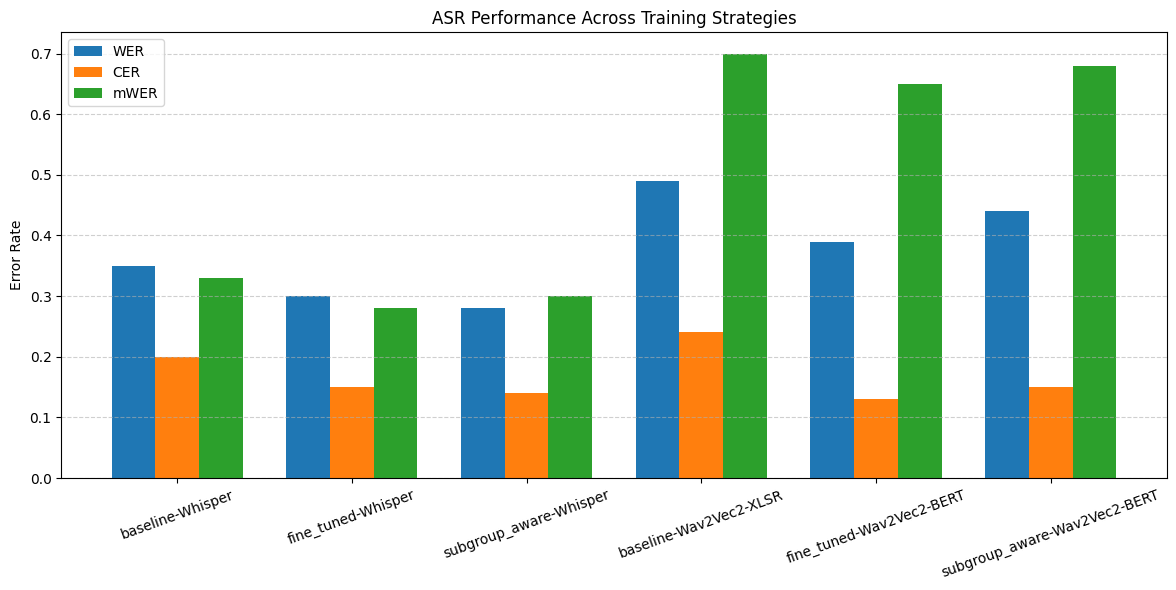

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data
models = [e["model"] for e in experiments]
wer  = [e["wer"]  for e in experiments]
cer  = [e["cer"]  for e in experiments]
mwer = [e["mWER"] for e in experiments]

x = np.arange(len(models))
width = 0.25

# Plot
plt.figure(figsize=(12, 6))
plt.bar(x - width, wer,  width, label="WER")
plt.bar(x,         cer,  width, label="CER")
plt.bar(x + width, mwer, width, label="mWER")

plt.xticks(x, models, rotation=20)
plt.ylabel("Error Rate")
plt.title("ASR Performance Across Training Strategies")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

In [ ]:
experiments = [
    {
        "model": "baseline-Whisper",
        "wer_by_gender": {
            "Male": 0.49,
            "Female": 0.53
        },
        "wer_by_age": {
            "<18yrs": 0.53,
            "19-25": 0.46,
            "41-55": 0.42,
            "unknown": 0.61
        },
        "wer_by_accent": {
            "pidgin": 0.50
        },
        "wer_by_domain": {
            "clinical": 0.45,
            "general": 0.58
        }
    },
    {
        "model": "fine_tuned-Whisper",
        "wer_by_gender": {
            "Male": 0.29,
            "Female": 0.32
        },
        "wer_by_age": {
            "<18yrs": 0.38,
            "19-25": 0.26,
            "41-55": 0.31,
            "unknown": 0.32
        },
        "wer_by_accent": {
            "pidgin": 0.30
        },
        "wer_by_domain": {
            "clinical": 0.26,
            "general": 0.36
        }
    },
    {
        "model": "subgroup_aware-Whisper",
        "wer_by_gender": {
            "Male": 0.28,
            "Female": 0.27
        },
        "wer_by_age": {
            "<18yrs": 0.29,
            "19-25": 0.26,
            "41-55": 0.31,
            "unknown": 0.29
        },
        "wer_by_accent": {
            "pidgin": 0.28
        },
        "wer_by_domain": {
            "clinical": 0.26,
            "general": 0.29
        }
    },
    {
        "model": "baseline-Wav2Vec2-XLSR",
        "wer_by_gender": {
            "Male": 0.51,
            "Female": 0.44
        },
        "wer_by_age": {
            "<18yrs": 0.45,
            "19-25": 0.49,
            "41-55": 0.47,
            "unknown": 0.49
        },
        "wer_by_accent": {
            "pidgin": 0.48
        },
        "wer_by_domain": {
            "clinical": 0.49,
            "general": 0.47
        }
    },
    {
        "model": "fine_tuned-Wav2Vec2-BERT",
        "wer_by_gender": {
            "Male": 0.43,
            "Female": 0.34
        },
        "wer_by_age": {
            "<18yrs": 0.40,
            "19-25": 0.43,
            "41-55": 0.32,
            "unknown": 0.34
        },
        "wer_by_accent": {
            "pidgin": 0.39
        },
        "wer_by_domain": {
            "clinical": 0.41,
            "general": 0.35
        }
    },
    {
        "model": "subgroup_aware-Wav2Vec2-BERT",
        "wer_by_gender": {
            "Male": 0.46,
            "Female": 0.41
        },
        "wer_by_age": {
            "<18yrs": 0.51,
            "19-25": 0.45,
            "41-55": 0.42,
            "unknown": 0.38
        },
        "wer_by_accent": {
            "pidgin": 0.44
        },
        "wer_by_domain": {
            "clinical": 0.45,
            "general": 0.43
        }
    }
]

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_wer_by_subgroup(experiments, subgroup_key, title):
    models = [e["model"] for e in experiments]

    # collect all subgroup labels
    subgroups = sorted({
        sg
        for e in experiments
        for sg in e[subgroup_key].keys()
    })

    x = np.arange(len(models))
    width = 0.8 / len(subgroups)

    plt.figure(figsize=(12, 5))

    for i, sg in enumerate(subgroups):
        values = [
            e[subgroup_key].get(sg, np.nan)
            for e in experiments
        ]
        plt.bar(
            x + i * width,
            values,
            width,
            label=sg
        )

    plt.xticks(
        x + width * (len(subgroups) - 1) / 2,
        models,
        rotation=20,
        ha="right"
    )
    plt.ylabel("WER")
    plt.title(title)
    plt.legend(title="Subgroup")
    plt.grid(axis="y", linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.show()

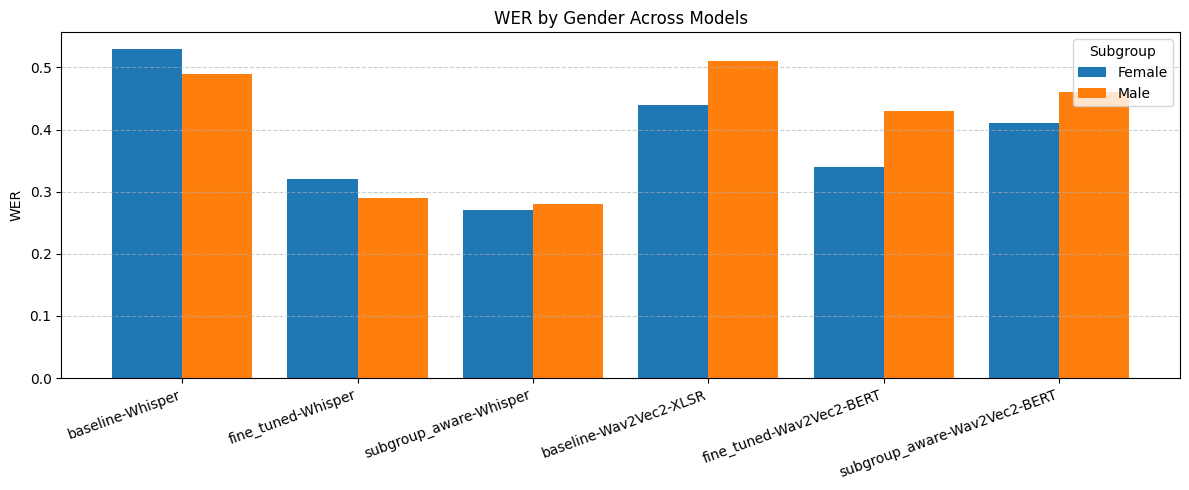

In [ ]:
plot_wer_by_subgroup(
    experiments,
    subgroup_key="wer_by_gender",
    title="WER by Gender Across Models"
)


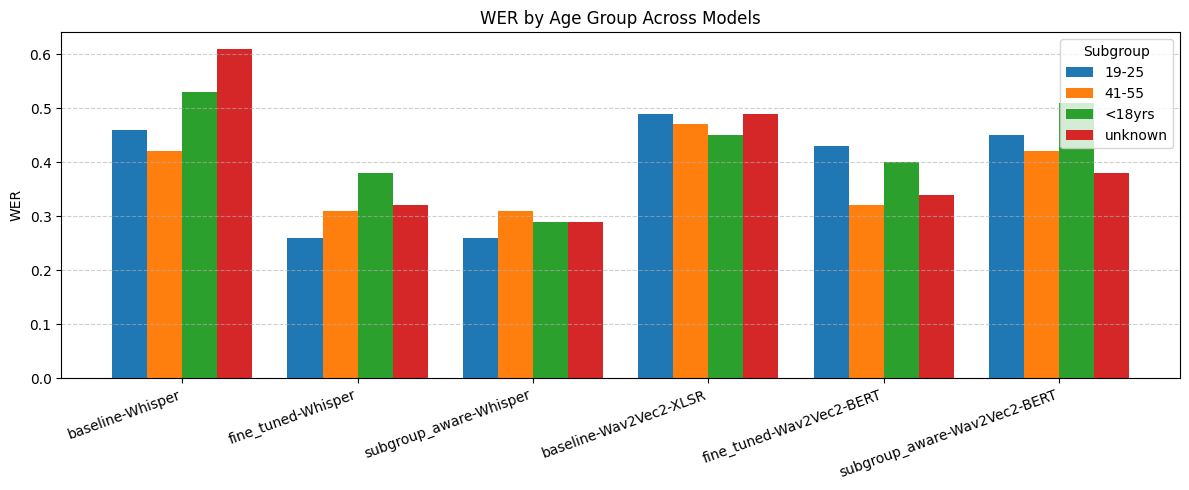

In [ ]:
plot_wer_by_subgroup(
    experiments,
    subgroup_key="wer_by_age",
    title="WER by Age Group Across Models"
)

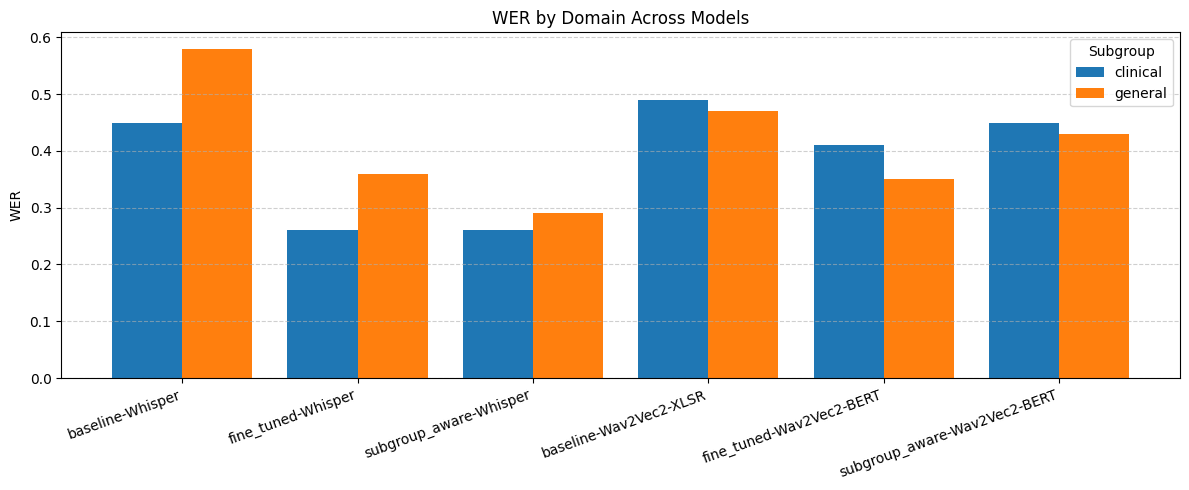

In [ ]:
plot_wer_by_subgroup(
    experiments,
    subgroup_key="wer_by_domain",
    title="WER by Domain Across Models"
)

In [ ]:
experiments = [
    {
        "model": "baseline-Whisper",
        "wer_by_intersectional_subgroup": {
            "19-25|Male|clinical": 0.38,
            "19-25|Female|clinical": 0.47,
        },
    },
    {
        "model": "fine_tuned-Whisper",
        "wer_by_intersectional_subgroup": {
            "19-25|Male|clinical": 0.28,
            "19-25|Female|clinical": 0.13,
        },
    },
    {
        "model": "subgroup_aware-Whisper",
        "wer_by_intersectional_subgroup": {
            "19-25|Male|clinical": 0.28,
            "19-25|Female|clinical": 0.13,
        },
    },
    {
        "model": "baseline-Wav2Vec2-XLSR",
        "wer_by_intersectional_subgroup": {
            "19-25|Male|clinical": 0.51,
            "19-25|Female|clinical": 0.37,
        },
    },
    {
        "model": "fine_tuned-Wav2Vec2-BERT",
        "wer_by_intersectional_subgroup": {
            "19-25|Male|clinical": 0.44,
            "19-25|Female|clinical": 0.36,
        },
    },
    {
        "model": "subgroup_aware-Wav2Vec2-BERT",
        "wer_by_intersectional_subgroup": {
            "19-25|Male|clinical": 0.46,
            "19-25|Female|clinical": 0.38,
        },
    }
]

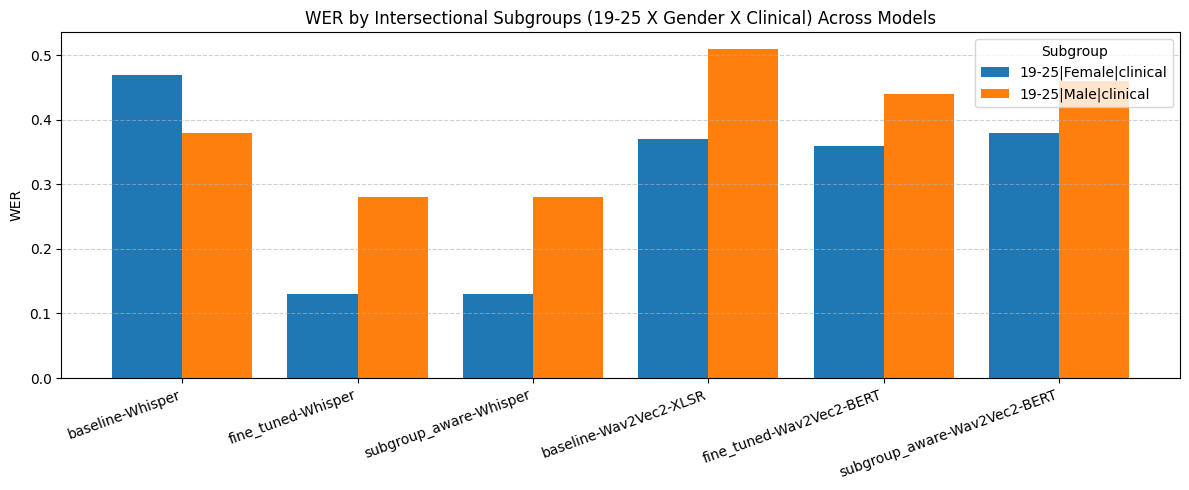

In [ ]:
plot_wer_by_subgroup(
    experiments,
    subgroup_key="wer_by_intersectional_subgroup",
    title="WER by Intersectional Subgroups (19-25 X Gender X Clinical) Across Models"
)

In [ ]:
clinical_subset = clinical_df.rename(columns={
    "transcript": "reference",
    "whisper_pred": "whisper_prediction",
    "wav2vec2_pred": "wav2vec2_prediction"
})


In [ ]:
clinical_subset = clinical_subset.drop(columns=
 ["domain", "gender", "age_group", "country", "duration", "path", "audio_id"])

In [ ]:
clinical_subset = clinical_subset.drop(columns=["speaker_id", "accent"])

In [ ]:
import jiwer
import numpy as np

def utterance_wer(ref, hyp):
    if not isinstance(ref, str) or not isinstance(hyp, str):
        return np.nan
    if ref.strip() == "":
        return np.nan
    return jiwer.wer(ref, hyp)

In [ ]:
clinical_subset["whisper_prediction"] = (
    clinical_subset["whisper_prediction"]
    .apply(normalize_text)
)

In [ ]:
clinical_subset["wer_whisper"] = [
    utterance_wer(r, h)
    for r, h in zip(
        normalize_texts(clinical_subset["reference"]),
        normalize_texts(clinical_subset["whisper_prediction"])
    )
]

clinical_subset["wer_wav2vec2"] = [
    utterance_wer(r, h)
    for r, h in zip(
        normalize_texts(clinical_subset["reference"]),
        normalize_texts(clinical_subset["wav2vec2_prediction"])
    )
]

In [ ]:
clinical_subset["mwer_whisper"] = [
    medical_wer(r, h, medical_terms)
    for r, h in zip(
        normalize_texts(clinical_subset["reference"]),
        normalize_texts(clinical_subset["whisper_prediction"])
    )
]

clinical_subset["mwer_wav2vec2"] = [
    medical_wer(r, h, medical_terms)
    for r, h in zip(
        normalize_texts(clinical_subset["reference"]),
        normalize_texts(clinical_subset["wav2vec2_prediction"])
    )
]

In [ ]:
clinical_subset.head()

,reference,whisper_prediction,wav2vec2_prediction,subgroup,wer_whisper,wer_wav2vec2,mwer_whisper,mwer_wav2vec2
1,managementi n primary hyperparathyroidism surg...,management and primary hyperparaderoism so the...,manidment and primary hypof pyroderoism clogic...,19-25|Male|clinical,0.727273,0.818182,0.833333,1.000000
2,minor anaphylactic reactions such as urticaria...,mino anaphilatic reactions such as it is carri...,minor andaphilatic rasions such as bitish kare...,19-25|Male|clinical,0.714286,0.714286,0.500000,0.875000
3,type ii saccular diverticulum of an extrahepat...,type 2 circular davatic color of an extra hypa...,type two sircula levaticolo of an estra ypatic...,19-25|Male|clinical,0.777778,0.666667,1.000000,1.000000
4,the nature of a chronic ulcer white or red les...,the nature of the chronic ulcer white or red l...,the inature of a chronic osa white or read lyt...,19-25|Male|clinical,0.142857,0.380952,0.142857,0.857143
5,cesarean delivery does not prevent perinatal t...,cesarean s delivery does not prevent perinatal...,cesarind liri does not prevent perineta transm...,19-25|Male|clinical,0.333333,0.666667,0.000000,1.000000


In [ ]:
clinical_subset.to_json(
    "baseline_clinical_predictions.json",
    orient="records",
    indent=2,
    force_ascii=False
)